In [1]:
from numpy.typing import ArrayLike
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import root
from typing import Callable
from utils import plot_state_dynamics
import matplotlib.pyplot as plt
import numpy as np

# Modeling the State Dynamics Alone

In [2]:
Tmax = 1e8
Nmax = 10_309_278

# Growth Constants
gT = 1/90
gN = 1/147

# Rate of cell circulation (Units: cell/Day)
rCD = 1.21e5
rNK = rCD * 1.5

# Turn over rates (Units: 1/Day)
kN = 1/147
kCD = 9e-3   
kNK = 1/14

# Competition constants (Units: 1/(cell * day))
a4 = 3.422e-10          # Death/Inactivation of CD8+ cells by interacting with the tumor
a5 = 1e-7               # Death/Inactivation of NK cells by interacting with the tumor
a2 = 7.13e-10           # Fractional (non)-ligand-transduced tumor cell kill by NK cells
a3 = a2 * 5             # Fractional (non)-ligand-transduced tumor cell kill by NK cells
a1 = (a2 + a3) / 100    # Death of Tumor cells by competition with Normal epithelial cells
a0 = (a2 + a3) / 5


ode_constants = (Tmax, Nmax, gT, gN, rCD, rNK, kN, kCD, kNK, a0, a1, a2, a3, a4, a5)

In [3]:
def cancer_dynamics(t:float, y:ArrayLike, ode_const:tuple) -> ArrayLike:
    """Define the cancer dynamics excluding the MMK portions.
    
    Parameters:
        - t (float) : the time at which to compute the derivatives.
        - y (ArrayLike) : the estimated values of the states.
        - ode_const (tuple) : a tuple containing all the constants
                              for the dynamics of the state EXCLUDING
                              MMK.
    
    Returns:
        - (ArrayLike) : the derivatives of the cancer dynamics.
    """
   
    T, N, CD, NK = y
    Tmax, Nmax, gT, gN, rCD, rNK, kN, kCD, kNK, a0, a1, a2, a3, a4, a5 = ode_const
    
    dT = gT*T*np.log(Tmax / T) - a1*N*T - a2*NK*T - a3*CD*T
    dN = gN*N*np.log(Nmax / N) - kN*N - a0*N*T
    dCD = rCD - kCD*CD  - a4*CD*T
    dNK = rNK - kNK*NK  - a5*NK*T

    return np.array([dT, dN, dCD, dNK])

In [4]:
cancer0 = np.array([1e6, 1e7, 1.21e3, 1.815e3])
t0, t1, tf = 0, 120, 156
t_span = (t0, t1)
cancer_sol = solve_ivp(fun=cancer_dynamics, t_span=t_span, y0=cancer0, dense_output=True, max_step=0.1, args=(ode_constants, ))

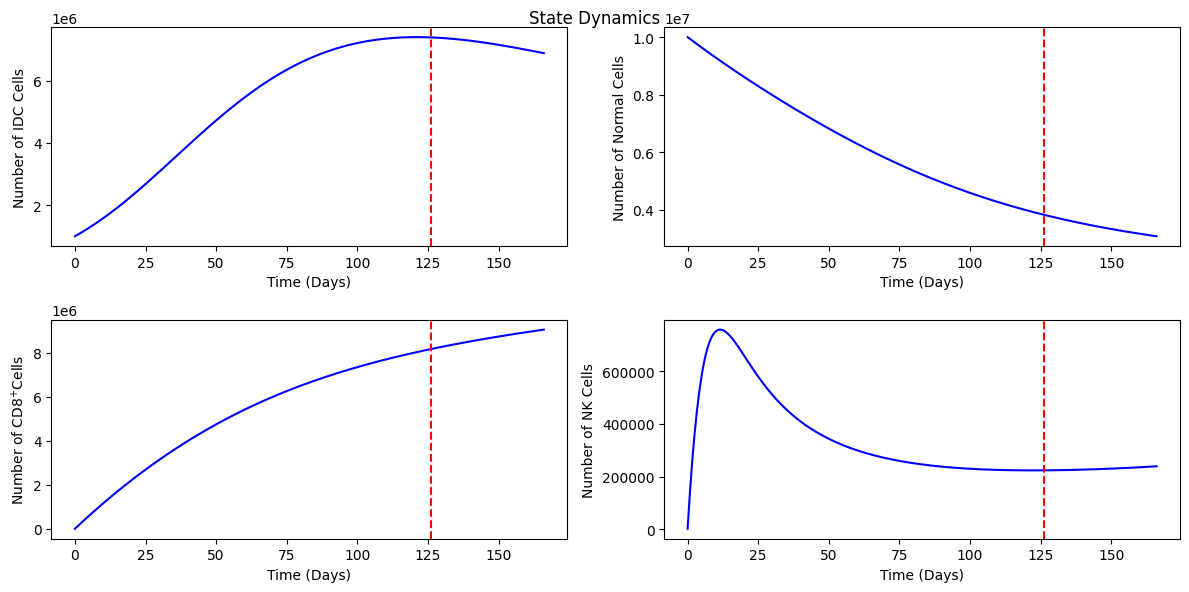

In [5]:
plot_state_dynamics(cancer_sol, tf=166)

# Modeling the State Dynamics with MMK

In [12]:
# MMK for CD8+ (Computational Model by DePillis)
i = 1
rho0 = 1.245e-2   # Units 1\Day
alpha0 = 2.019e7  # Cells

# MMK for NK
# Used for IL-2 supplementation in dePillis so I estimated
j = 2
rho1 = rho0*5  
alpha1 = alpha0 * 1.5

mmk_constants = (i, rho0, alpha0, j, rho1, alpha1)

In [13]:
def cancer_MMK_dynamics(t:float, y:ArrayLike, ode_const:tuple, mmk_const:tuple) -> ArrayLike:
    """Define the cancer dynamics incorporating the MMK portions.
    
    Parameters:
        - t (float) : the time at which to compute the derivatives.
        - y (ArrayLike) : the estimated values of the states.
        - ode_const (tuple) : a tuple containing all the constants
                              for the dynamics of the state EXCLUDING
                              MMK.
        - mmk_const (tuple) : a tuple containing the constants ONLY for
                              MMK.
    
    Returns:
        - (ArrayLike) : the derivatives of the cancer dynamics.
    """
   
    T, N, CD, NK = y
    Tmax, Nmax, gT, gN, rCD, rNK, kN, kCD, kNK, a0, a1, a2, a3, a4, a5 = ode_const
    i, ρ0, α0, j, ρ1, α1 = mmk_const
    
    dT = gT*T*np.log(Tmax / T) - a1*N*T - a2*NK*T - a3*CD*T 
    dN = gN*N*np.log(Nmax / N) - kN*N - a0*N*T
    dCD = rCD - kCD*CD  - a4*CD*T + (ρ0 * CD * T**i)/(α0 + T**i)
    dNK = rNK - kNK*NK  - a5*NK*T + + (ρ1 * CD * T**j)/(α1 + T**j)

    return np.array([dT, dN, dCD, dNK])

In [14]:
cancer0 = np.array([3e6, 1e7, 1.21e3, 1.815e3])
t0, t1, tf = 0, 120, 156
t_span = (t0, t1)
cancer_mmk_sol = solve_ivp(fun=cancer_MMK_dynamics, t_span=t_span, y0=cancer0, dense_output=True, max_step=0.1, args=(ode_constants, mmk_constants))

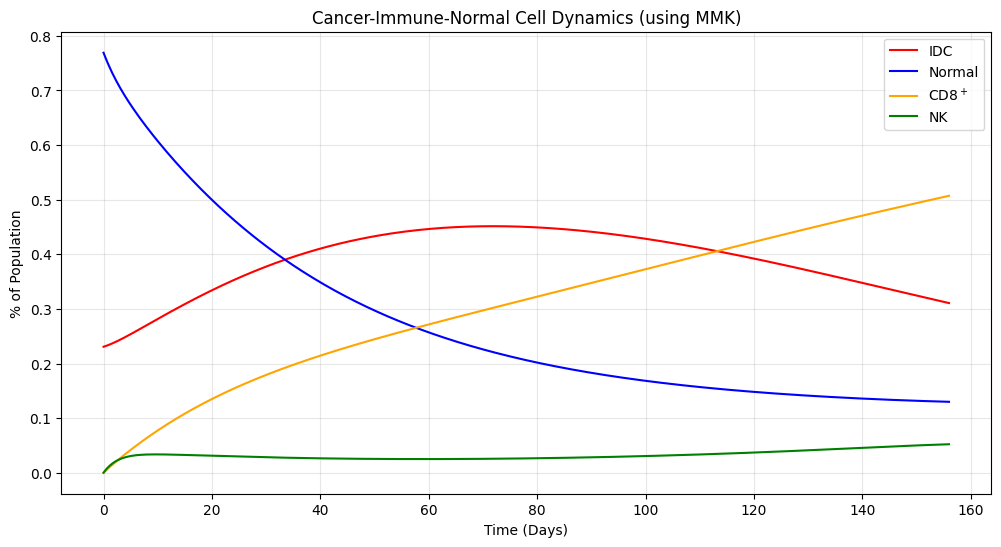

In [15]:
plot_state_dynamics(cancer_mmk_sol, tf=156, title='Cancer-Immune-Normal Cell Dynamics (using MMK)', normalize=True, use_grid=True, animate=False)

# Solving for optimal control

In [4]:
# Doxorubicin
fD = 1
Ed = 0.9

# Cyclophosphamide
fC = 4/5
Ec = 0.9
bCD = 0.5

chemo_constants = (fD, Ed, fC, Ec, bCD)

In [5]:
def state_equations(t:float, y:ArrayLike, u_interp:Callable, ode_const:tuple, mmk_const:tuple, chemo_const:tuple) -> ArrayLike:
    """Define the cancer dynamics incorporating MMK and chemotherapy.
    
    Parameters:
        - t (float) : the time at which to compute the derivatives.
        - y (ArrayLike) : the estimated values of the states.
        - u_interp (Callable) : a callable function to compute the 
                                chemo (control) at a given time t.
        - ode_const (tuple) : a tuple containing all the constants
                              for the dynamics of the state EXCLUDING
                              MMK.
        - mmk_const (tuple) : a tuple containing the constants ONLY for
                              MMK.
        - chemo_const (tuple) : a tuple containing the constants ONLY 
                                for chemo.
    
    Returns:
        - (ArrayLike) : the derivatives of the cancer dynamics.
    """

    T, N, CD, NK = y
    Dd, Dc = u_interp(t)
    Tmax, Nmax, gT, gN, rCD, rNK, kN, kCD, kNK, a0, a1, a2, a3, a4, a5 = ode_const
    i, ρ0, α0, j, ρ1, α1 = mmk_const
    fD, Ed, fC, Ec, bCD = chemo_const

    
    dT = gT*T*np.log(Tmax / T) - a1*N*T - a2*NK*T - a3*CD*T - (fC * Ec * Dd + fD * Ed * Dc) * T
    dN = gN*N*np.log(Nmax / N) - kN*N - a0*N*T
    dCD = rCD - kCD*CD  - a4*CD*T + (ρ0 * CD * T**i)/(α0 + T**i) - bCD * Dc * CD
    dNK = rNK - kNK*NK  - a5*NK*T + + (ρ1 * CD * T**j)/(α1 + T**j)

    return np.array([dT, dN, dCD, dNK])

In [6]:
def costate_equations(t, y, state_sol:Callable, u_interp:Callable, ode_const:tuple, mmk_const:tuple, chemo_const:tuple):
    """
    
    """

    T, N, CD, NK = state_sol.sol(t)
    Dd, Dc = u_interp(t)
    Tmax, Nmax, gT, gN, rCD, rNK, kN, kCD, kNK, a0, a1, a2, a3, a4, a5 = ode_const
    i, ρ0, α0, j, ρ1, α1 = mmk_const
    fD, Ed, fC, Ec, bCD = chemo_const
    p1, p2, p3, p4 = y

    dp1 = - (-gT*p1 + gT*p1*np.log(Tmax/T) - a1*p1*N - a2*p1*NK - a3*p1*CD - p1*(fC*Ec*Dc + fD*Ed*Dd) - a0*p2*N 
              + ((α0 + T**i) * (i*ρ0*p3*CD*(T**(i-1))) - (ρ0*p3*CD*(T**i) * (i*(T**(i-1)))))/((α0 + T**i)**2)
              - a4*p3*CD + ((α1 + T**j) * (j*ρ1*p4*NK*(T**(j-1))) - (ρ1*p4*NK*(T**j) * (j*(T**(j-1)))))/((α1 + T**j)**2)
              - a5*p4*NK - 2*T) 
    dp2 = - (-a1*p1*T + gN*p2*np.log(Nmax/N) - gN*p2 - kN*p2 - a0*p2*T)
    dp3 = - (-a3*p1*T - kCD*p3 - p3*((ρ0*(T**i)) /(α0 + T**i)) - a4*p3*T - bCD*p3*Dc)
    dp4 = - (-a2*p1*T - kNK*p4 - p4*((ρ1*(T**j)) /(α1 + T**j)) - a5*p4*T)

    return np.array([dp1, dp2, dp3, dp4])    

In [7]:
epsilon = 0.01
test = epsilon + 1
max_step = 0.1
ξ126 = 150
ξc = 75
ξd = 75

state0 = np.array([1e6, 1e7, 1.21e3, 1.815e3])
t0, t1, tf = 0, 126, 156
t_span1 = (t0, t1)
t_span1b = (t1, t0)
costate126 = np.zeros(shape=4)
costate126[0] = - ξ126 * 1

num_vals = 2500
time1 = np.linspace(t0, t1, num=num_vals)
time1b = np.linspace(t1, t0, num=num_vals)
control = np.zeros((2, num_vals))                                  # [Doxo, 
                                                                   #  Cyclo]
control[0], control[1] = np.log(1_700*0.9), np.log(127.5*0.9)

In [10]:
while test > epsilon:

    old_control = control.copy()
    control_interp = CubicSpline(time1, y=control, axis=1)
    
    # Solve state forwards (t0 -> t1) [T N CD NK]
    state_solu = solve_ivp(fun=state_equations, t_span=t_span1, t_eval=time1, y0=state0, max_step=max_step,
                           args=(control_interp, ode_constants, mmk_constants, chemo_constants), dense_output=True)

    # Solve costate backward (t1 -> t0)
    costate_solu = solve_ivp(fun=costate_equations, t_span=t_span1b, y0=costate126, t_eval=time1b, max_step=max_step,
                             args=(state_solu, control_interp, ode_constants, mmk_constants, chemo_constants), dense_output=True)
    
    states = state_solu.y
    costates = costate_solu.y[:, ::-1]

    γ1, λ1, γ2, λ2 = 50, 2, 50, 2
    γ3, λ3, γ4, λ4 = 50, 2, 50, 2
    
    def rootu(u):
       
       u = u.reshape((2, num_vals))

       DH_Du1 = -(4/5) * costates[0] * Ec - costates[2] * bCD * states[2] - 2 * ξc * u[1] +\
                 (γ3 * λ3 * (u[1] - np.log(127.5))**(λ3 - 1) / (1 + (u[1] - np.log(127.5))**λ3)**2) +\
                 (γ4 * λ4 * (u[1] - np.log(104.55))**(λ4 - 1) / (1 + (u[1] - np.log(104.55))**λ4)**2)
       DH_Du2 = - Ed * costates[0] * states[0] - 2 * ξd * u[0] +\
                  (γ1 * λ1 * (u[0] - np.log(1_700))**(λ1 - 1) / (1 + (u[0] - np.log(1_700))**λ1)**2) +\
                  (γ2 * λ2 * (u[0] - np.log(1_394))**(λ2 - 1) / (1 + (u[0] - np.log(1_394))**λ2)**2)
       
       return (np.array([DH_Du1, DH_Du2])).flatten()

    root_control = root(fun=rootu, x0=control.flatten())
    control = root_control.x
    control = control.reshape((2, num_vals))
    control[0] = np.clip(control[0], np.log(1394), np.log(1700))
    control[1] = np.clip(control[1], np.log(104.55), np.log(127.5))
    test = (np.abs(old_control - control)).sum()

KeyboardInterrupt: 

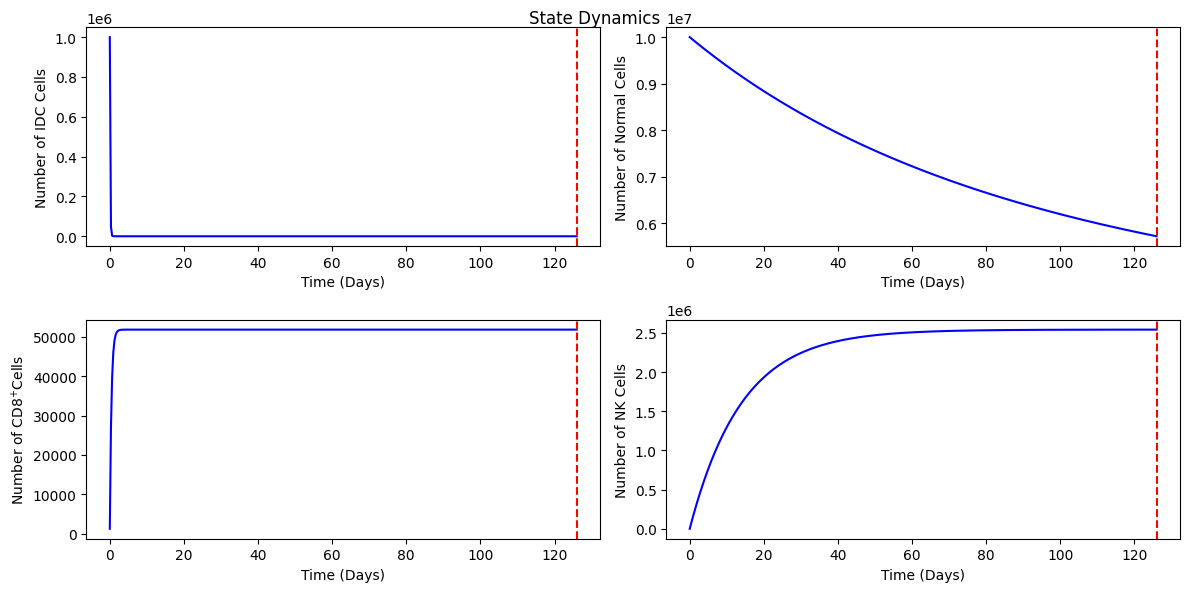

In [12]:
plot_state_dynamics(state_solu, tf=126)

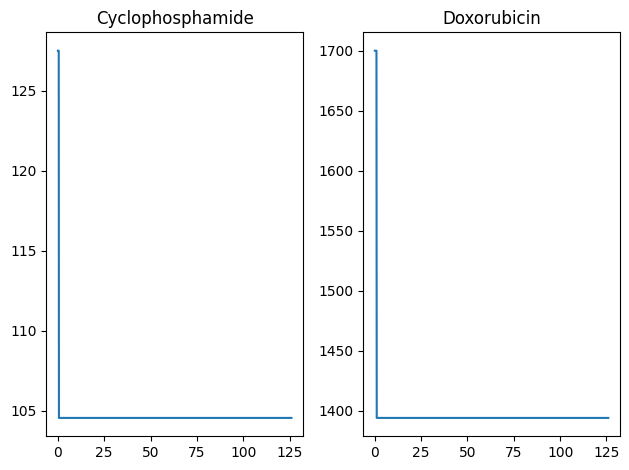

In [25]:
ax =  plt.subplot(121)
ax.plot(time1, np.exp(control[1]))
ax.set_title('Cyclophosphamide')
ax = plt.subplot(122)
ax.plot(time1, np.exp(control[0]))
ax.set_title('Doxorubicin')
plt.tight_layout()
plt.show()